In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.8.0


In [11]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')

In [17]:
os.path.dirname(dataset)

'.'

In [18]:
os.listdir(dataset_dir)

['README.md', 'test', 'train']

In [19]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [21]:
sample_file = os.path.join(train_dir, 'csharp/0.txt')
with open(sample_file) as f:
  print(f.read())

"how to pause loop while time is ticking i have made a timer where i can set time i want to wait and then do something..so this is my short timer func:..private void sleep(int interval, action action).{.    system.windows.forms.timer mytimer = new system.windows.forms.timer();.    mytimer.interval = interval; //interval is in ms   .    mytimer.start();.    mytimer.tick += (s, e) =&gt;.    {.        action();.        mytimer.stop();.    };.}...and im using this timer in loop:..foreach (string word in words).{.   sleep(5000, ()=&gt; myaction());                                           .}...without loop timer is great but in loop it wont work because loop wont stop and wait for those 5secs. it do all stuff imediately and starts timer again and again too fast...so what im trying to find out is how to make my loop wait until time runs out and myaction() is executed. im working on forms application so all threadin sleeps wont work here. also i tried all other timers but they used too much 

In [7]:
# remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)

In [22]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [23]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [25]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [26]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [27]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


the reviews contain various HTML tags like <.br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [28]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [29]:
max_features = 10000
sequence_length = 250  #cümle bittikten sonra padding yapılır ve uzunluk 250ye ulaşana kadar 0 eklenir
# You'll also define some constants for the model, like an explicit maximum sequence_length, 
# which will cause the layer to pad or truncate sequences to exactly sequence_length values.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,  
    output_mode='int', #to create unique integer indices for each token
    output_sequence_length=sequence_length)

In [30]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [31]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [32]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [33]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  saw
 313 --->  source
Vocabulary size: 10000


In [34]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
embedding_dim = 16

In [45]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
________________________________________________

In [46]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [47]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 4s 18ms/step - loss: 1.3804 - accuracy: 0.3316 - val_loss: 1.3711 - val_accuracy: 0.4869
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 1.3557 - accuracy: 0.4483 - val_loss: 1.3369 - val_accuracy: 0.5362
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 1.3101 - accuracy: 0.5352 - val_loss: 1.2825 - val_accuracy: 0.5856
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 1.2449 - accuracy: 0.5928 - val_loss: 1.2128 - val_accuracy: 0.6494
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 1.1670 - accuracy: 0.6391 - val_loss: 1.1354 - val_accuracy: 0.6725
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 1.0853 - accuracy: 0.6828 - val_loss: 1.0616 - val_accuracy: 0.7069
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 1.0136 - accuracy: 0.7189 - val_loss: 0.9919 - val_accuracy: 0.7387
Epoch

In [48]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 2s 9ms/step - loss: 0.8629 - accuracy: 0.7398
Loss:  0.862949550151825
Accuracy:  0.7397500276565552


#### Create a plot of accuracy and loss over time

In [49]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

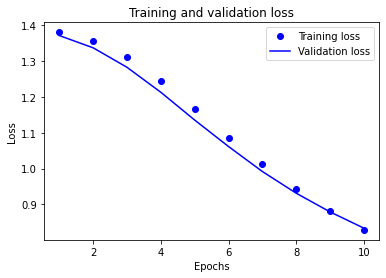

In [50]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

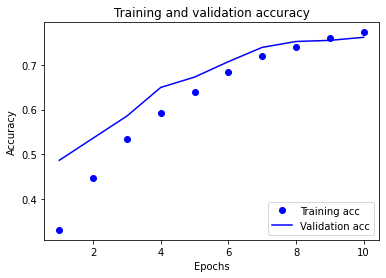

In [51]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the **tf.keras.callbacks.EarlyStopping** callback.

## Export the model

In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [53]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 3s 9ms/step - loss: 0.8629 - accuracy: 0.7398
0.7397500276565552


### Inference on new data
To get predictions for new examples, you can simply call model.predict()

In [59]:
examples = [
    "This is my opinion about above 5 output.  's1==s2' > true : Because those two objects point same reference 'welcome' in the string pool.  's3==s4' >false *** : I don't know exactly. Is this same situation with 's1==s3' is false?  's1.equals(s3)' >true : since the two different object(?) contain the same characters in the same order  's4.intern()==s4' >false **really curious : s4.intern() is pointing s2's reference. But s2 and s4 is not same object. so False?  's5==s2' : s5 is s1 . And s1 is same as s2.  Is my opinion is true? I really need a help...I have a exam soon Thank you all!",
    "Issues with openpyxl not reading all rows in sheet",
    "Blazor inject class using UserManager into razor page",
    "Return action being performed before the firestore update OnCompleteListener?"
]

export_model.predict(examples)

array([[0.55099267, 0.46926844, 0.51456267, 0.44470054],
       [0.5143919 , 0.44864222, 0.5349378 , 0.4832888 ],
       [0.5216985 , 0.47788736, 0.5511503 , 0.43599528],
       [0.50840634, 0.4616436 , 0.5688652 , 0.44808877]], dtype=float32)